In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
from keras.metrics import MeanIoU, Accuracy

In [2]:
# unzip 2d images of lung CT
path = '2d_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_images')
    
# unzip 2d masks of lung CT
path = '2d_masks.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_masks')

In [3]:
# load tiff images
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


In [4]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ 1st arg: (# of numpy set(x_data, y_data), length of numpy set, height, width, color channel)

In [5]:
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img

# convert mask images to numpy arrays
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    y_data[i] = img

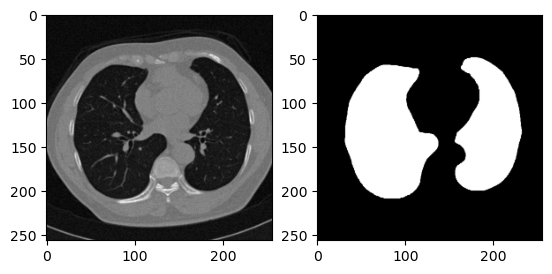

In [6]:
# scale image arrays
# scaling benefits learning process 
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[50].squeeze(), cmap='gray')
ax[1].imshow(y_data[50].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [7]:
# split dataset into train and validation datasets with 20% test portion
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(213, 256, 256, 1)
(54, 256, 256, 1)


In [8]:
def attention_block(input_encoder, input_decoder, filters):
    # Attention mechanism
    g = Conv2D(filters, (1, 1), activation='relu')(input_encoder)
    x = Conv2D(filters, (1, 1), activation='relu')(input_decoder)
    attn = Concatenate(axis=-1)([g, x])
    attn = Conv2D(filters, (1, 1), activation='relu')(attn)
    attn = Conv2D(1, (1, 1), activation='sigmoid')(attn)

    # Apply attention to decoder feature maps
    attn_decoder = Multiply()([attn, input_decoder])

    return attn_decoder

def attention_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Contracting path (Encoder)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Expansive path (Decoder)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    up1 = UpSampling2D(size=(2, 2))(conv2)

    # Apply attention block
    attn_decoder = attention_block(conv1, up1, 128)

    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(attn_decoder)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Example usage
input_shape = (256, 256, 1)  # Modify according to your data
num_classes = 1  # Background and lung regions

model = attention_unet(input_shape, num_classes)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [20]:
#train model
model_checkpoint = ModelCheckpoint('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/att_unet_1.h5', monitor='loss', save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=4, callbacks=[model_checkpoint, callback])

Epoch 1/10
54/54 [==============================] - 209s 4s/step - loss: 0.1129 - accuracy: 0.9288
Epoch 2/10
54/54 [==============================] - 209s 4s/step - loss: 0.1103 - accuracy: 0.9282
Epoch 3/10
54/54 [==============================] - 202s 4s/step - loss: 0.1209 - accuracy: 0.9242
Epoch 4/10
54/54 [==============================] - 202s 4s/step - loss: 0.0830 - accuracy: 0.9409
Epoch 5/10
54/54 [==============================] - 187s 3s/step - loss: 0.0931 - accuracy: 0.9369
Epoch 6/10
54/54 [==============================] - 184s 3s/step - loss: 0.0806 - accuracy: 0.9418
Epoch 7/10
54/54 [==============================] - 186s 3s/step - loss: 0.0929 - accuracy: 0.9347
Epoch 8/10
54/54 [==============================] - 180s 3s/step - loss: 0.0977 - accuracy: 0.9334
Epoch 9/10
54/54 [==============================] - 192s 4s/step - loss: 0.0840 - accuracy: 0.9407


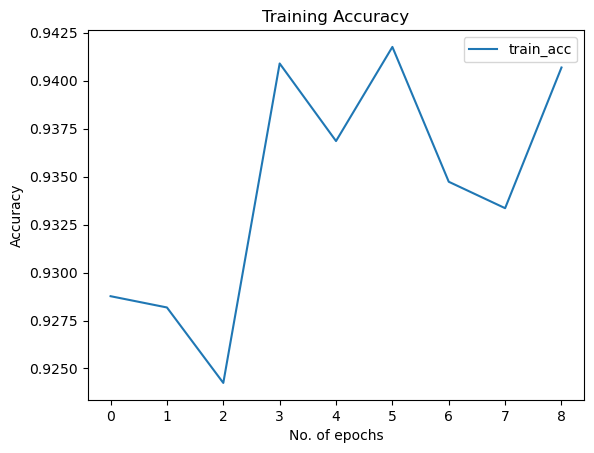

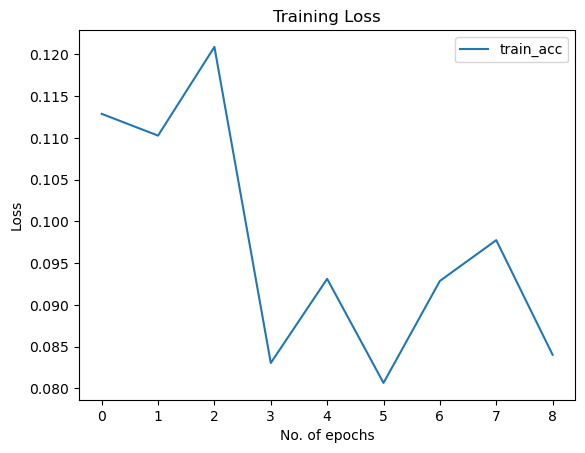

In [22]:
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.plot(history.history['loss'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

2/2 [==============================] - 17s 4s/step


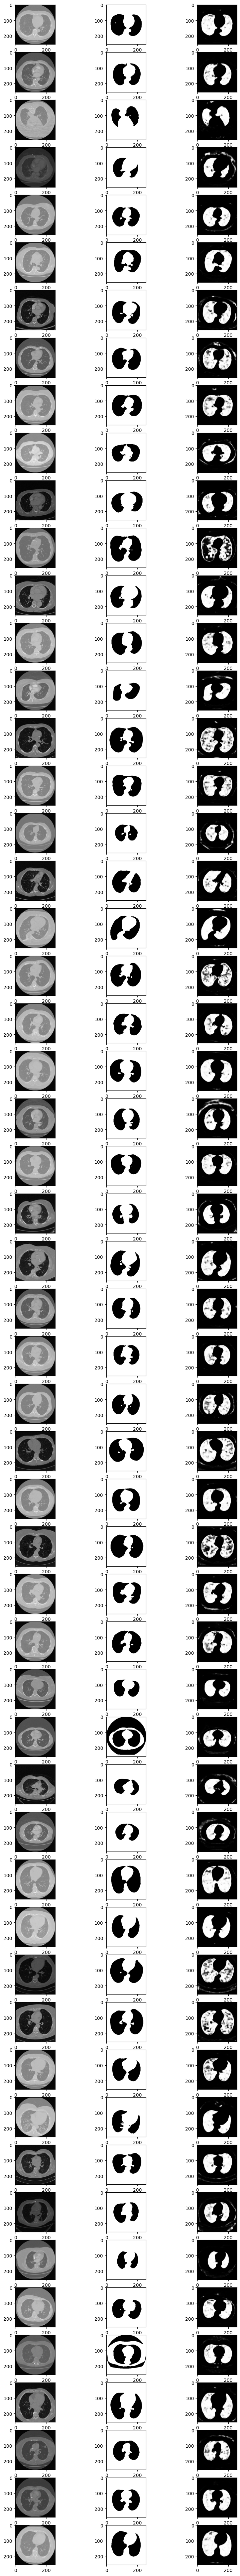

In [23]:
# predict segmentation
model.load_weights('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/att_unet_1.h5')
y_pred = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(y_pred):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

In [28]:
meaniou = MeanIoU(4, name=None, dtype=None)
meaniou.update_state(y_val, y_pred.argmax(axis=-1))
print('mean IoU = ', meaniou.result().numpy())
meaniou.reset_states()

acc = Accuracy()
acc.update_state(y_val, y_pred.argmax(axis=3))
print('acc = ', acc.result().numpy())
acc.reset_states()

def get_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(0,1,2))
    union = np.sum(y_true**2, axis=(0,1,2)) + np.sum(y_pred**2, axis=(0,1,2))
    dc = 2 * intersection / union
    return dc

dice_coeff = get_dice(y_val, y_pred)
print('dc = ', np.mean(dice_coeff))

# y_val = (y_val>0.5)
# # y_pred = (y_pred>0.5)
# cm = confusion_matrix(y_val.ravel(), y_pred.argmax(axis=3).ravel())
# print(cm)

# cr = classification_report(y_val.ravel(), y_pred.argmax(axis=3).ravel(), zero_division=0)
# print(cr)

# k = cohen_kappa_score(y_val.ravel(), y_pred.argmax(axis=3).ravel())
# print('k = ', k)

mean IoU =  0.118097514
acc =  0.23619503
dc =  0.015694614458070823
